## Prediction of Survival of Promoted Teams in the Premier League  

# The Problem
The premier league is fast becoming the most competitive football league in the world, and part of this competitiveness is also seen in the battle to survive relegation. Almost every major football league in the world has a relegation system, where teams at the bottom of the table are relegated and have to play at least the next season in a lower division. The place left by these teams are filled in by top teams in the lower division. This happens every season and creates a rotating roster of teams.

But, because of a gap in resources that is between the different leagues, what we see is that a lot of times teams that are promoted in a season are also relegated after the end of the same season. But is there real data behind the anecdote or is it just an extrapolation of just a few examples ? And are there some ways we can predict if a promoted team will survive or get relegated ?

# Our Solution - 
We will try to create a Logistic Model to predict if a promoted team will survive relegation, using variables that are of significance. We will also check if it is actually true that promoted teams are more likely to get relegated and if the 40 point mark is actually of importance in survival.


# Why are we using a Logistic Regression Model - 
As the main point that we are worried about is whether a team survives or not, we can use categorical data to create our model. By marking teams that survived as ‘1’ and teams that got relegated as ‘0’, we can create a model to categorise the data. <br>
As there have only been 30 seasons of the premier league, and each season about three teams get relegated, we don’t have a big collection of data (about 90 entries). Therefore it's much better to use a much easier method like logistic regression than to use a more data extensive method.


# 1. Importing Packages

In [1]:
#Importing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as mtp
from sklearn.linear_model import LogisticRegression
import seaborn as sbr

# 2. Exploring the Dataset

In [2]:
#Reading the Dataset
ds = pd.read_csv(r'Promoted_Teams.csv')
ds.head()

,Season,Name,Prom,Money_Spent,Pts,Gl_Scored,Gl_Conc,Survival
0,92/93,Ipswich Town,1,0.75,52,50,55,1
1,92/93,Middlesbrough,2,3.18,44,54,75,0
2,92/93,Blackburn,3,11.84,71,68,46,1
3,93/94,Newcastle,1,6.60,77,82,41,1
4,93/94,West Ham,2,2.01,52,47,58,1


The dataset contains 8 Columns - <br> 
1. Season - The Season the team got promoted. The dataset spans seasons from 1992/1993 to the 2022/2023 with each season having three entries, except for the 1995/96 season, which only had two teams promoted. This leads to a total of 92 rows of entries.  
2. Name - The Name of the team that got Promoted.  
3. Prom - The way the team got promoted. This column is categorical, divided into 3 columns -  
    1. The team came first in the Championship and got automatic promotion, represented as '1'.
    2. The team came second in the Championship and got automatic promotion, represented as '2'.
    3. The team came somewhere between 3rd and 6th, and qualified by winning the Playoff tournament between the 4 teams. Represented as '3'.
4. Money_Spent - Money Spent (in Millions) by the team that season.  
5. Pts - Points accumulated by the team in that season after they got promoted.  
6. Gl_Scored - No. of Goals Scored by the team that season.  
7. Gl_Conc - No. of Goals Conceded by the team that season.
8. Survival - Categorical variable representing whether the team survived, or got relegated that season. Survival represented as 1, while relegation represented as 0.


#   2.1 Applying Graphical Analysis to the Dataset

<p>In all graphs presented below, teams that survived their first season in the league are represented in blue, while the teams that were relegated are represented in red. This is done to help us easily visualise differences and some salient points that might be missed otherwise.</p>

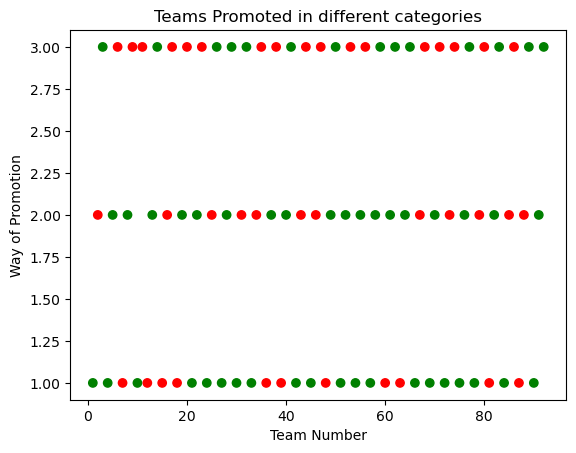

In [3]:
x = range(1, 93)
colors = {1 : 'Green', 0 : 'red'} # Green stands for Survival, red stands for relegation
Prom_Sct = mtp.scatter(x = x, y = ds.Prom, c = ds.Survival.map(colors), alpha = 1) 
mtp.title("Teams Promoted in different categories")
mtp.xlabel("Team Number")
mtp.ylabel("Way of Promotion")
mtp.show()

By plotting the different ways the teams get promoted, we find that teams that were directly promoted were more likely survive than teams that were promoted via the playoffs in general. This suggests that the way a team got promoted is a factor that we need to consider in our model.

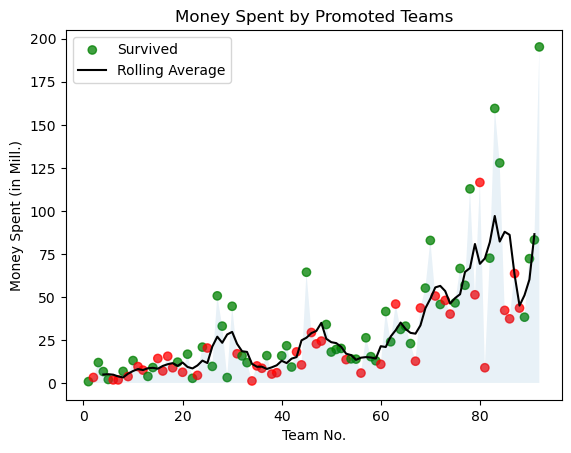

In [118]:
#Money Spent
mtp.scatter(x, ds.Money_Spent, c = ds.Survival.map(colors), alpha = 0.75, label = 'Survived')
mtp.fill_between(x, ds.Money_Spent, alpha = 0.1)
rm = ds.Money_Spent.rolling(5).mean() # Rolling Mean to analyse the trensd the data is following
mtp.plot(rm, c = 'black', label = 'Rolling Average')
mtp.title("Money Spent by Promoted Teams")
mtp.xlabel("Team No.")
mtp.ylabel("Money Spent (in Mill.)")
mtp.legend()
mtp.show()

<p>The graph for Money Spent shows that there is a trend in the amount spent. More money is being spent by the teams as seasons go. A big part of this could be explained by inflation, while it can also be explained by the growing financial power of the Premier League. This creates a problem as this would give more weight to the values representing the later seasons, skewing the Model. </p>
<p>This can also be seen in the following graph where there are more extreme values which can affect the model, while showing a bit of overlap.</p>

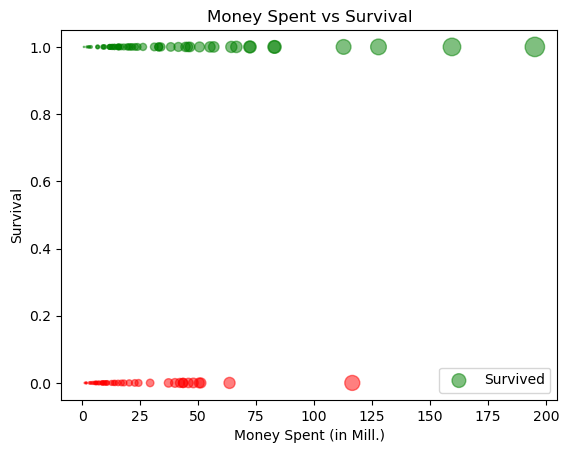

In [119]:
mtp.scatter(ds.Money_Spent, ds.Survival, c = ds.Survival.map(colors), s = ds.Money_Spent, alpha = 0.5, label = 'Survived')
# Size of points related to the amount of money spent by the teams, more the money spent, more the size of the corresponding point.
mtp.xlabel("Money Spent (in Mill.)")
mtp.ylabel("Survival")
mtp.title("Money Spent vs Survival")
mtp.legend()
mtp.show()

# 2.1.1 Improving on Money_Spent

<p>To make sure the model is not effected by the trend present in the Money_Spent variable, we will take use of the Total_Exp file.</p>
<p>Total_Exp is a file that contains the total amount of money spent by all the teams present in the league. By dividing the amount of Money spent by the teams to the total money spent that season, we would create a new variable that would be without the trend of increasing spending and give us the money spent with relation to the total league spend.</p>

In [120]:
mds = pd.read_csv(r'Total_Exp.csv')
mds.head()

,Season,Total_Exp
0,92/93,63.57
1,93/94,87.75
2,94/95,139.29
3,95/96,205.69
4,96/97,187.35


<function matplotlib.pyplot.show(close=None, block=None)>

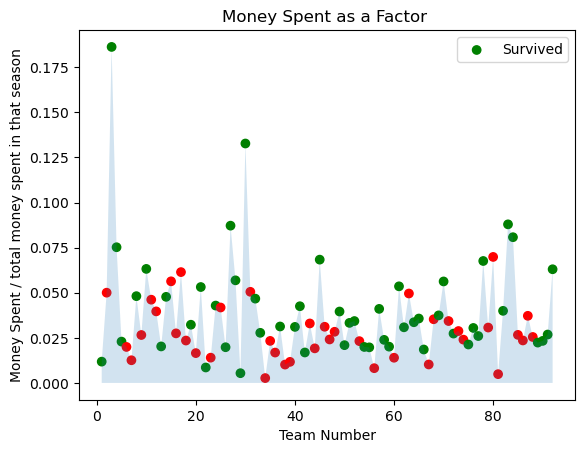

In [121]:
Exp_Factor = []
for a in range(0,92):
    for b in range(0,31):
        if ds.Season[a] == mds.Season[b]:
            Exp_Factor.append(ds.Money_Spent[a] / mds.Total_Exp[b]) # Exp_Factor is the money spent by the teams in relation to total money spent that season by teams.
mtp.scatter(x, Exp_Factor, c = ds.Survival.map(colors), label = 'Survived')
mtp.fill_between(x, Exp_Factor, alpha = 0.2)
mtp.title("Money Spent as a Factor ")
mtp.xlabel("Team Number")
mtp.ylabel("Money Spent / total money spent in that season")
mtp.legend()
mtp.show

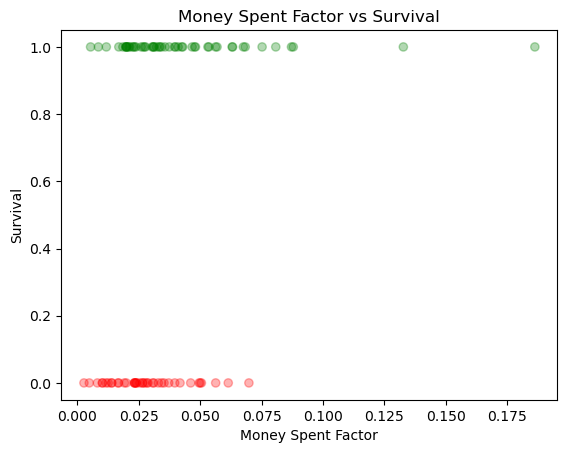

In [122]:
mtp.scatter(Exp_Factor, ds.Survival, c = ds.Survival.map(colors), alpha = 0.3)
mtp.title("Money Spent Factor vs Survival")
mtp.xlabel("Money Spent Factor")
mtp.ylabel("Survival")
mtp.show()

<p> The 2 graphs shown above show that the new variable Exp_Factor is a better representation, and suits the model better as it has no trends. Therefore, we can confidently remove Money_Spent and replace it with Exp_Factor. </p>
<p> In the First Graph, almost all the values are in a similar range, showing that there are no implicit trends present in the variable. </p>
<p> In the second Graph, Except of two values, all the other values are close to each other. This means that we don't need to worry about extreme values affecting the model severly. </p>

In [123]:
#Replacing Money_Spent with Exp_Factor
ds.Money_Spent = Exp_Factor
ds.head()

,Season,Name,Prom,Money_Spent,Pts,Gl_Scored,Gl_Conc,Survival
0,92/93,Ipswich Town,1,0.011798,52,50,55,1
1,92/93,Middlesbrough,2,0.050024,44,54,75,0
2,92/93,Blackburn,3,0.186251,71,68,46,1
3,93/94,Newcastle,1,0.075214,77,82,41,1
4,93/94,West Ham,2,0.022906,52,47,58,1


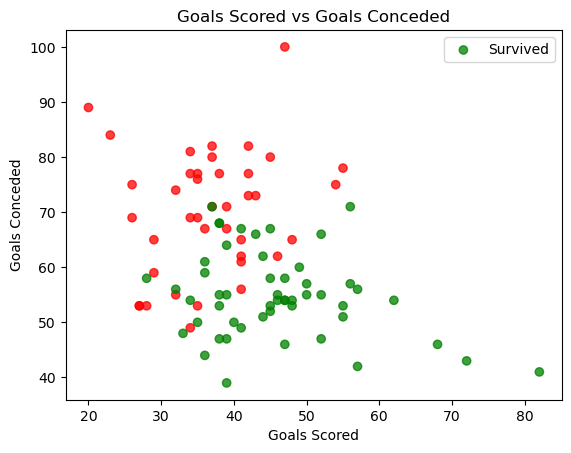

In [124]:
# Goal Scored and Goal Conceded
mtp.scatter(ds.Gl_Scored, ds.Gl_Conc, c = ds.Survival.map(colors), alpha = 0.75, label = 'Survived')
mtp.xlabel("Goals Scored")
mtp.ylabel("Goals Conceded")
mtp.title("Goals Scored vs Goals Conceded")
mtp.legend()
mtp.show()

<p> The graph between Goals Scored and Goals Conceded confirms our intial ideas. </p>
<p> Scoring more goals and conceding less do play a part in the survival. While these graphs may look pointless as the points they make sound rudimentary, they do provide a proof to the points. Plus we get some salients that we might miss otherwise. </p>

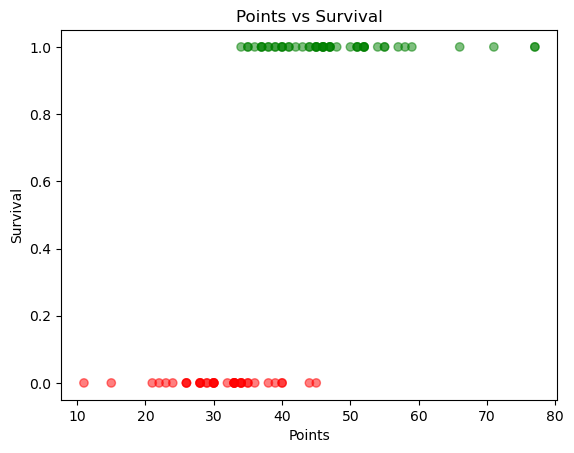

In [125]:
#Pts vs Survival
mtp.scatter(ds.Pts, ds.Survival, c = ds.Survival.map(colors), alpha = 0.5)
mtp.title("Points vs Survival")
mtp.xlabel("Points")
mtp.ylabel("Survival")
mtp.show()

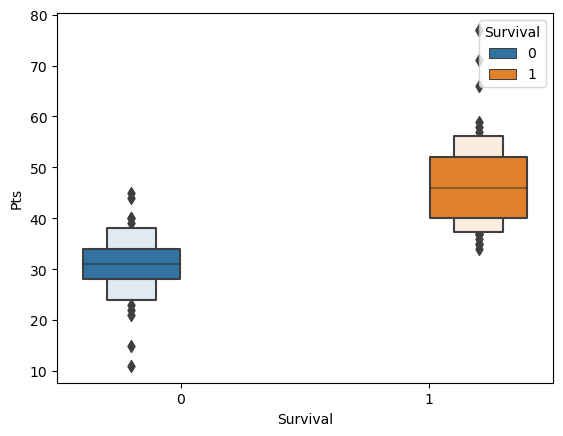

In [4]:
sbr.boxenplot(data = ds, x = 'Survival', y = 'Pts', hue = 'Survival')
mtp.show()

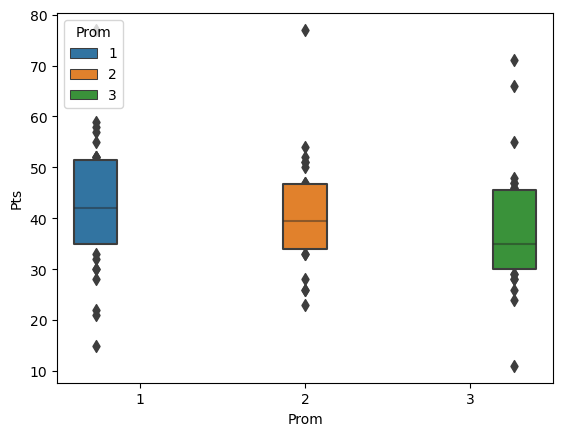

In [5]:
sbr.boxenplot(data = ds, x = 'Prom', y = 'Pts', hue = 'Prom')
mtp.show()

# 3. No. of Teams the got Relegated after Promotion.

In [126]:
total = ds['Survival'].sum()
# 'total' represents the no. of teams that survived relegation 
print("No. of Teams that have survived relegation after getting promoted - ", total)
print("Percentage of Teams that have survived relegation after getting promoted - ", round(total/92, 2))

No. of Teams that have survived relegation after getting promoted -  52
Percentage of Teams that have survived relegation after getting promoted -  0.57


<p> The fact that 57 % of teams survive their first season after promotion show that there is not much merit in the fact that teams that are recently promoted should not be automatically considered to be condidates to be relegated. </p>
<p> But we should also take in note that because of the relatively small data size, this percentage could change heavily after a season or two. </p>

# 4. Finding relation between Concerned Variables

In [7]:
# Creating a new dataframe 'new_ds' to create a Correlation Matrix for the data
new_ds = ds.drop(columns = ['Season', 'Name '])
new_ds.head()

,Prom,Money_Spent,Pts,Gl_Scored,Gl_Conc,Survival
0,1,0.75,52,50,55,1
1,2,3.18,44,54,75,0
2,3,11.84,71,68,46,1
3,1,6.60,77,82,41,1
4,2,2.01,52,47,58,1


In [8]:
cor_ds = new_ds.corr()
#Correlation Matrix
cor_ds.style.background_gradient(cmap = 'coolwarm', axis = None).format(precision = 4)


,Prom,Money_Spent,Pts,Gl_Scored,Gl_Conc,Survival
Prom,1.0000,0.0092,-0.1617,-0.0732,0.2234,-0.1603
Money_Spent,0.0092,1.0000,-0.0060,-0.1153,-0.0238,0.2186
Pts,-0.1617,-0.0060,1.0000,0.8048,-0.7188,0.6940
Gl_Scored,-0.0732,-0.1153,0.8048,1.0000,-0.3261,0.4452
Gl_Conc,0.2234,-0.0238,-0.7188,-0.3261,1.0000,-0.6300
Survival,-0.1603,0.2186,0.6940,0.4452,-0.6300,1.0000


Some interesting things that the Correlation Matrix shows that - 
1. Points are more affected by the goals scored, whereas Survival of a team is more affected by goals conceded.  
2. Goals Scored and Goals Conceded are not highly related, meaning we can use both, rather than combining them in a single variable, such as Goal Difference.  
3. Money_Spent is not as big of a factor as we previously thought. 
4. Promotion type is the factor that least affects Survival. Also as stated above, directly Promoted teams has  a higher chance of Survival than teams that got promoted via the Playoff.

In [129]:
cor_ds.loc[['Gl_Scored'],['Gl_Conc']]

,Gl_Conc
Gl_Scored,-0.326056


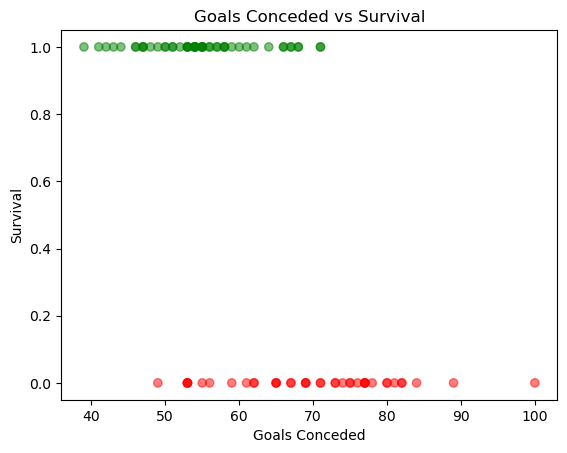

In [130]:
mtp.scatter(ds.Gl_Conc, ds.Survival, c = ds.Survival.map(colors), alpha = 0.5)
mtp.title("Goals Conceded vs Survival")
mtp.xlabel("Goals Conceded")
mtp.ylabel("Survival")
mtp.show()

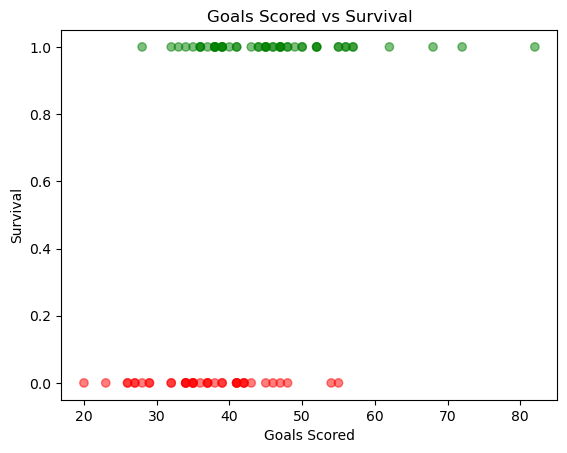

In [131]:
mtp.scatter(ds.Gl_Scored, ds.Survival, c = ds.Survival.map(colors), alpha = 0.5)
mtp.title("Goals Scored vs Survival")
mtp.xlabel("Goals Scored")
mtp.ylabel("Survival")
mtp.show()

# 5. Splitting the Dataset for Training and Testing

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
dep = ds.drop(columns = ['Name ', 'Season', 'Survival'] )
dep.head()
# Dataset containing dependent variables

,Prom,Money_Spent,Pts,Gl_Scored,Gl_Conc
0,1,0.75,52,50,55
1,2,3.18,44,54,75
2,3,11.84,71,68,46
3,1,6.60,77,82,41
4,2,2.01,52,47,58


In [11]:
Indep = ds.Survival
Indep.head()
# Dataset containing the Independent Variable Survival

0    1
1    0
2    1
3    1
4    1
Name: Survival, dtype: int64

In [12]:
x_train, x_test, y_train, y_test = train_test_split(dep, Indep, test_size = 0.3, random_state = 92)

In [13]:
x_train.head()

,Prom,Money_Spent,Pts,Gl_Scored,Gl_Conc
32,1,11.78,45,47,54
54,2,13.83,47,56,71
37,3,5.15,33,41,62
52,3,13.54,30,42,82
79,3,116.50,26,34,81


In [14]:
y_train.head()

32    1
54    1
37    0
52    0
79    0
Name: Survival, dtype: int64

# 6. Fitting the Logistic Regression Model

In [15]:
lr = LogisticRegression(random_state = 79).fit(x_train, y_train)
lr.predict(x_train)

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
      dtype=int64)

In [16]:
print("Score for Training Set = ",round(lr.score(x_train, y_train), 4))
print("Score for the Test Set = ", round(lr.score(x_test, y_test), 4))

Score for Training Set =  0.9062
Score for the Test Set =  0.8929


In [19]:
print("Intercept = ", lr.intercept_)
print("Coeefficients = ", lr.coef_)
print("Logistic Equation = ", lr.intercept_, " + ", lr.coef_, " * X ")

Intercept =  [-11.18713551]
Coeefficients =  [[ 0.12538049  0.03712275  0.42101844  0.02163202 -0.10373852]]
Logistic Equation =  [-11.18713551]  +  [[ 0.12538049  0.03712275  0.42101844  0.02163202 -0.10373852]]  * X 


# 7. Standardizing the Data to create a Second Model

<p> While we get a decent model, we would like to find a way to make it better. One way that we can try is to standardized the dataset. One of the reason to do this is to get a uniform scale for all the data, as Exp_Factor is between 0 to 1, while the rest of the factors are between 20 to 100. So by standerdizing the data, we can hopefully get a better model with data more standardized and within scale of each other. </p>

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [21]:
sc_dep = dep.drop(columns = ['Prom'])
scaler.fit(sc_dep)
sc_dep = scaler.fit_transform(sc_dep)
sc_dep = pd.DataFrame(sc_dep.reshape(92, 4))
sc_dep['Prom'] = dep['Prom'].to_numpy()
sc_dep = sc_dep.rename(str, axis = "columns")
sc_dep.head()

,0,1,2,3,Prom
0,-0.876971,0.994087,0.788008,-0.542918,1
1,-0.805987,0.320378,1.176211,1.127599,2
2,-0.553012,2.594146,2.534919,-1.294651,3
3,-0.706082,3.099428,3.893627,-1.712280,1
4,-0.840164,0.994087,0.496857,-0.292340,2


In [22]:
x2_train, x2_test, y2_train, y2_test = train_test_split(sc_dep, Indep, test_size = 0.3, random_state = 92)

In [23]:
lr2 = LogisticRegression(random_state=79).fit(x2_train, y2_train)
lr2.predict(x2_train)

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
      dtype=int64)

In [24]:
print("Score for Training set = ", round(lr2.score(x2_train, y2_train), 4))
print("Score for Test Set = ", round(lr2.score(x2_test, y2_test), 4))

Score for Training set =  0.9062
Score for Test Set =  0.8929


<p> The Standardized data gives a model that is similar to the original, so both models so equal benefits.</p>

In [25]:
print("Intercept = ", lr2.intercept_)
print("Coefficeints = ", lr2.coef_)
print("Logistic Equation for Standardized data = ", lr2.intercept_, " + ", lr2.coef_, " * X ")

Intercept =  [1.34019488]
Coefficeints =  [[ 0.74340631  1.96829139  0.70196328 -1.15441589 -0.1961741 ]]
Logistic Equation for Standardized data =  [1.34019488]  +  [[ 0.74340631  1.96829139  0.70196328 -1.15441589 -0.1961741 ]]  * X 


# 8. Analysing the 40 Point Mark

<p> Here we replace the variable 'Pts' from a continous variable to a characteristic one. If a team has more than 40 points, the Pts variable is changed to 1. If not, the variable is changed to 0. This is to verify if the 40 point threshold as used by many figures in the footballing world are of real importance to the survival of a team or not. </p>

In [26]:
ds40 = pd.read_csv(r'Promoted_Teams.csv')
def change_40(number):
    if number <= 40:
        number = 0
    else:
        number = 1
    return number
ds40['Pts'] = ds40['Pts'].map(change_40)
ds40

,Season,Name,Prom,Money_Spent,Pts,Gl_Scored,Gl_Conc,Survival
0,92/93,Ipswich Town,1,0.75,1,50,55,1
1,92/93,Middlesbrough,2,3.18,1,54,75,0
2,92/93,Blackburn,3,11.84,1,68,46,1
3,93/94,Newcastle,1,6.60,1,82,41,1
4,93/94,West Ham,2,2.01,1,47,58,1
...,...,...,...,...,...,...,...,...
87,21/22,Watford,2,43.50,0,34,77,0
88,21/22,Brentford,3,38.20,1,48,53,1
89,22/23,Fulham,1,72.20,1,55,53,1
90,22/23,Bournemouth,2,83.10,0,37,71,1


In [27]:
total_40 = ds40['Pts'].sum()
# This is the sum of teams that have 40 or more Points 
print("No. of Teams with 40 or more Points = ", total_40)
print("Percentage of teams with 40 or more points - ", round(total_40 / 92, 2))

No. of Teams with 40 or more Points =  40
Percentage of teams with 40 or more points -  0.43


<p> Only 40 teams have more than 40 points. Meaning that, even if all the 40 teams here survived relegation, it will still not be able to accomodate 12 other teams that have survived relegation. This suggests that the 40 point mark is not as accurate as it is being made. </p>

In [28]:
dep40 = ds40.drop(columns = ['Name ', 'Season', 'Survival'])
# Creating a New Dataset for a logistic model
dep40.head()

,Prom,Money_Spent,Pts,Gl_Scored,Gl_Conc
0,1,0.75,1,50,55
1,2,3.18,1,54,75
2,3,11.84,1,68,46
3,1,6.60,1,82,41
4,2,2.01,1,47,58


In [29]:
indep40 = ds40.Survival
indep40.head()

0    1
1    0
2    1
3    1
4    1
Name: Survival, dtype: int64

In [30]:
x40_train, x40_test, y40_train, y40_test = train_test_split(dep40, indep40, test_size = 0.3, random_state = 92)

In [31]:
lr40 = LogisticRegression(random_state = 79).fit(x40_train, y40_train)
lr40.predict(x40_train)

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
      dtype=int64)

In [32]:
print("Score for training set = ", round(lr40.score(x40_train, y40_train), 4))
print("Score for test set = ", round(lr.score(x40_test, y40_test), 4))

Score for training set =  0.8594
Score for test set =  0.5


<p> The score for the test set confirms our suggestion that the 40 point mark is not as useful to make prediction about promotion and relegation as we had assumed before. </p>

In [33]:
print("Intercept = ", lr40.intercept_)
print("Coefficient = ", lr40.coef_)
print("Logistic Equation = ", lr40.intercept_, " + ", lr40.coef_, " *x ")

Intercept =  [4.99118274]
Coefficient =  [[-0.19179926  0.03681003  0.57806869  0.22050305 -0.23076148]]
Logistic Equation =  [4.99118274]  +  [[-0.19179926  0.03681003  0.57806869  0.22050305 -0.23076148]]  *x 
